In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Data Presentation and Pre-Processing
Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *

#import os
#data_base_path = os.path.join(os.pardir, 'data')
#data_folder = 'train.csv'
#data_path = os.path.join(data_base_path, data_folder)
#y, tX, ids = load_csv_data(data_path)

from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description (change later)
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000).

### Quick Pre-Processing

In [53]:
from implementations import *

In [4]:
# putting the meaningless values to "nan"
tX0 = np.where(tX==-999, np.nan,tX) #nanmin nanstd

In [ ]:
# OPTIONNAL: replaces the nan values by medians
med_X = np.nanmedian(tX, axis=0)
inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [ ]:
# ???????????????????
print(np.where(tX[0] == 2))

In [10]:
# remove categorical data and standarize the rest
ntX = np.delete(tX, 22, axis=1)
ntX = np.apply_along_axis(standardize, 1, ntX)

### Exploratory Analysis

Feature 2:


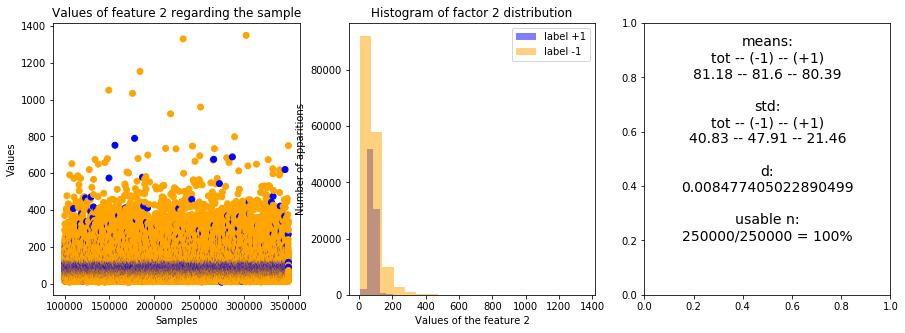

Feature 6:


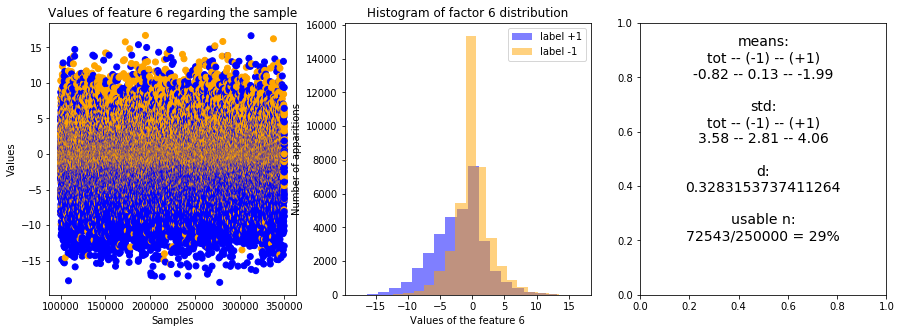

Feature 10:


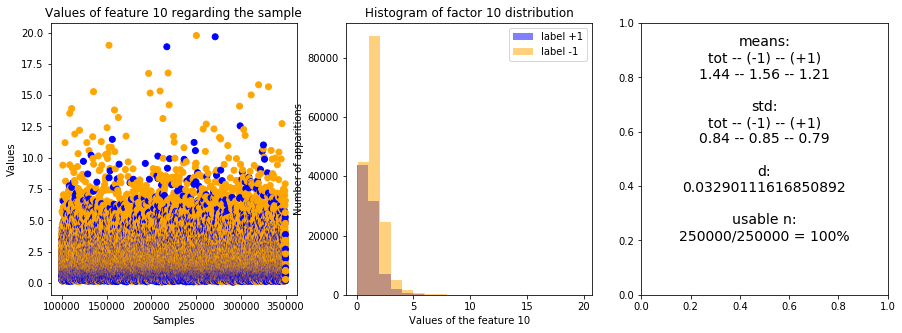

Feature 15:


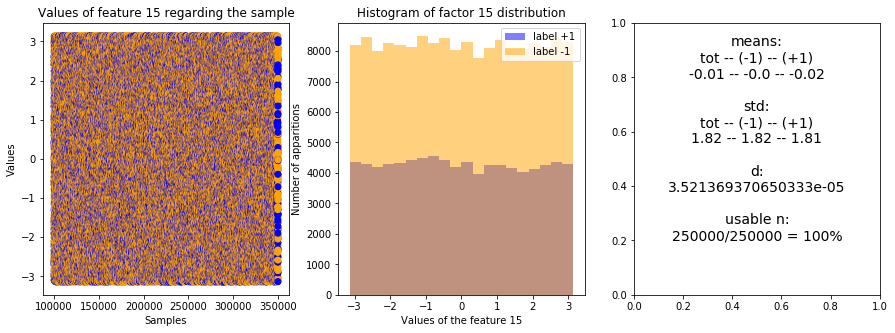

Feature 20:


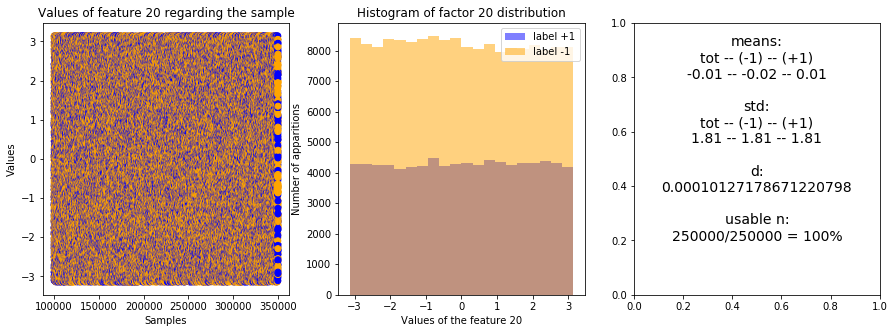

Feature 27:


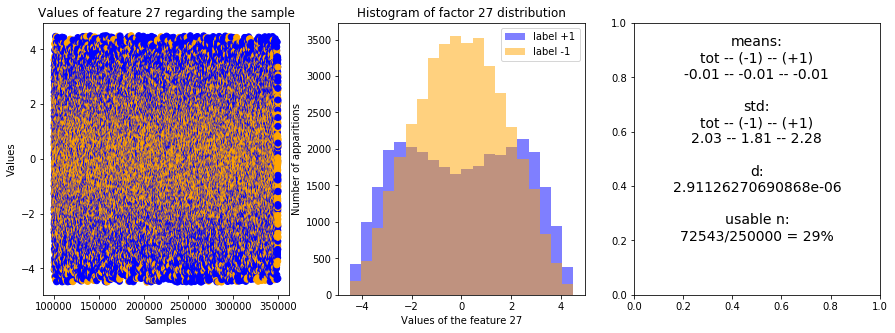

In [25]:
for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Feature Processing

**Least squares**

In [11]:
(w_ls, loss_ls) = least_squares(y, ntX)

print("w* ={w}\n\nmse={loss}".format(
    w=w_ls, loss=loss_ls))

w* =[ -1.43922038  -2.29715349  -2.33523905  -1.42725431 -22.97071986
  -1.35349122  -1.93383259  24.43143246  -1.68272263   1.32353787
 -29.84419641   5.44783042  20.52368574  -3.69755387  -1.76763277
  -1.60683379  -3.08504271  -1.93325701  -1.35166661  -1.31253644
  -1.33581076  -1.73520873  -1.73463634  -1.43522022  -1.50129328
  -1.91551352  -1.57014323  -1.77616081  -4.74454573]

mse=0.3712363247704449


**Least squares with Gradient Descent**

In [12]:
#define parameters

initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, ntX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

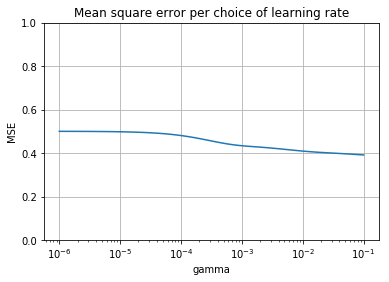

In [13]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [14]:
idx = np.argmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

w* =[ 0.17857706 -0.27255005 -0.09810048  0.18034538 -0.00043736  0.12978687
 -0.00045481  0.00572935 -0.0614304  -0.04458559  0.0009669   0.01378038
  0.00193316  0.13526023  0.00755395  0.00761807 -0.0648282   0.00757089
  0.0082243   0.03456587  0.00858867 -0.12168528  0.03076757  0.02661497
  0.02645478 -0.04289218  0.00125346  0.00074744 -0.09937497]

mse=0.39111632257317347

gamma=0.1


**Least squares with Stochastic Gradient Descent**

In [41]:
initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_sgd = [None] * len(gammas)
ws_sgd = [None] * len(gammas)
for g in range(len(gammas)):
    (ws_sgd[g], losses_sgd[g]) = least_squares_SGD(y, ntX, initial_w, max_iters, gammas[g])

523.7777269999997

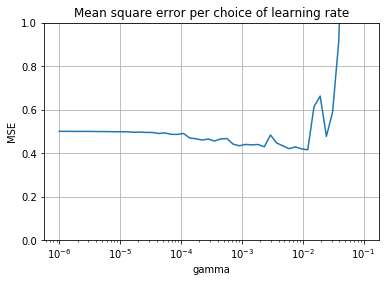

In [42]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [45]:
idx = np.argmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=ws_sgd[-1], loss=loss_sgd, gamma = gamma_sgd))

w* =[ 2.86234185e+12  4.45945130e+12  3.81605323e+12  2.21608287e+12
 -1.30950103e+12 -9.23040889e+12 -1.14714394e+12  3.42785659e+12
  3.11768318e+12  1.19779179e+12  3.46039621e+12  3.39511222e+12
 -1.30181461e+12  3.57100821e+12  3.39777435e+12  3.41802714e+12
  4.11637014e+12  3.48552036e+12  3.32855667e+12  2.07691836e+12
  3.35379266e+12 -3.16341103e+12 -1.34211829e+13 -1.03795005e+13
 -1.03547474e+13 -2.15721572e+12 -1.35116944e+12 -1.26048581e+12
  3.75844207e+11]

mse=0.4115102439160291

gamma=0.012067926406393288


**Ridge regression**

*Cross-validation hyperparameter selection*

In [47]:
seed = 1
degree = 2
k_fold = 4
lambdas = np.logspace(-15, -1, 50)

In [48]:
my = y[0:20000]
mtX = ntX[0:20000, :]

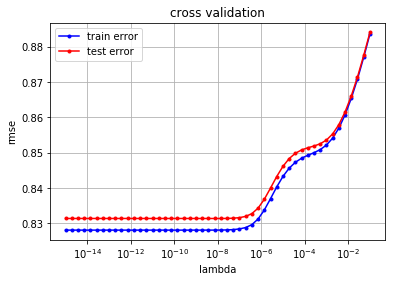

In [49]:
k_indices = build_k_indices(my, k_fold, seed)

rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(my, mtX, k_indices, k, lambda_, degree)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

In [50]:
idx = np.argmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

lambda* =7.1968567300115284e-09

rmse train=0.8280283548085515

rmse test=0.8313176396660873


*Bias-variance decomposition for complexity determination*

In [52]:
seeds = range(10)
ratio_train = 0.7
degrees = range(1, 12)

rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(mtX, my, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = least_squares(y_tr, tx_tr)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

NameError: name 'bias_variance_decomposition_visualization' is not defined

In [ ]:
poly = build_poly(mtX, 7)
print(poly.shape)

In [ ]:
seeds = range(10)
ratio_train = 0.7

x_tr, x_te, y_tr, y_te = split_data(mtX, my, ratio_train, seed)

In [ ]:
print(x_tr.shape)

In [ ]:
idx = np.argmin(rmse_te_cv)
degree_ri = degrees[idx]

print("degree* ={dergee}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx], rmse_te=rmse_te_bv[idx]))

### Overfitting vs Underfitting

### Methods application and visualization

# Machine Learning

In [ ]:
from implementations import *

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)